In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects
import matplotlib.pyplot as plt

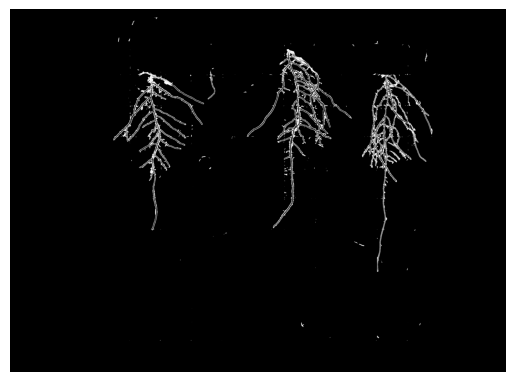

In [2]:
test_path = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task5/03_task5/task5_test_image_prediction_rayanedaborisova_220471.png'
test_loaded = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(test_loaded, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
def close_small_gaps(mask, threshold=0.1, iterations=3, kernel_size=(5, 3)):
    binary = (mask > int(threshold * 255)).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    cleaned_mask = remove_small_objects(binary.astype(bool), min_size=10)
    cleaned_mask = cleaned_mask.astype(np.uint8) * 255
    closed = cleaned_mask.copy()
    for _ in range(iterations):
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel)

    return closed

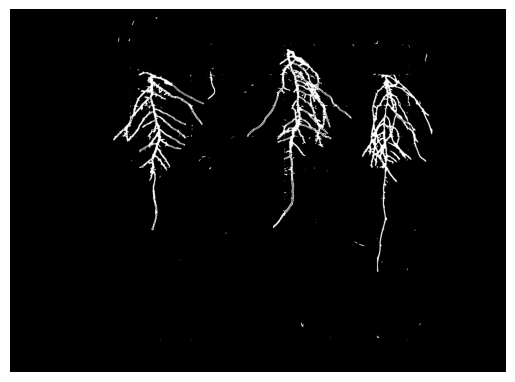

In [4]:
mask_closed = close_small_gaps(test_loaded, threshold=0.1)

plt.imshow(mask_closed, cmap='gray')
plt.axis('off')
plt.show()

In [5]:
def crop_empty_columns(mask, padding=20):
    """Remove empty columns on the sides (with an optional safety margin)."""
    occupied_columns = np.where(mask.sum(axis=0) > 0)[0]
    if occupied_columns.size == 0:                     # mask is all zeros
        return mask, (0, 0)

    left_crop  = max(occupied_columns[0] - padding, 0)
    right_crop = max(mask.shape[1] - occupied_columns[-1] - 1 - padding, 0)

    cropped_mask = mask[:, left_crop:mask.shape[1] - right_crop]
    return cropped_mask, (left_crop, right_crop)

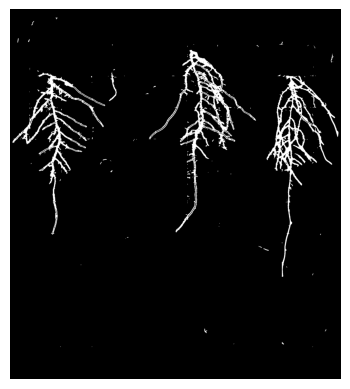

In [6]:
mask_cropped, (left_crop, right_crop) = crop_empty_columns(mask_closed, padding=20)

plt.imshow(mask_cropped, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
def components_touch(mask_a, mask_b, max_px_dist=15):
    kernel = np.ones((max_px_dist * 2 + 1, max_px_dist * 2 + 1), dtype=np.uint8)
    dilated = cv2.dilate(mask_a.astype(np.uint8), kernel, iterations=1)
    return np.any(np.logical_and(dilated, mask_b))

In [8]:
def place_bands(cluster_masks, img_width, num_bands, min_px):
    band_width = img_width / num_bands
    bands = [np.zeros_like(cluster_masks[0], np.uint8)
             for _ in range(num_bands)]

    for cm in cluster_masks:
        if cm.sum() < min_px:
            continue
        x, y, w, h = cv2.boundingRect(cm)
        cx = x + w / 2.0
        band_idx = min(int(cx // band_width), num_bands - 1)
        bands[band_idx] |= cm

    return [(m * 255).astype(np.uint8) for m in bands]

In [9]:
def segment_roots(mask, min_area=300, max_gap_px=5, num_roots=5, min_px_per_root=350):
    # 1. Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    comp_masks = []
    comp_centroids = []
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            mask_i = (labels == i).astype(np.uint8)
            comp_masks.append(mask_i)
            comp_centroids.append(centroids[i])

    # 2. Skip merging logic (to avoid grouping too many together)
    merged_masks = comp_masks.copy()

    # 3. Compute new centroids for clustering
    centroids = []
    for m in merged_masks:
        ys, xs = np.where(m)
        if xs.size:
            centroids.append([xs.mean(), ys.mean()])
    centroids = np.asarray(centroids)

    if centroids.size == 0:
        blank = np.zeros_like(mask, np.uint8)
        return [blank.copy() for _ in range(num_roots)]

    k = min(len(centroids), num_roots)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(centroids)

    cluster_masks = [np.zeros_like(mask, np.uint8) for _ in range(k)]
    for idx, m in enumerate(merged_masks):
        cluster_masks[labels[idx]] |= m

    # 4. Explode each cluster into individual root pieces (connected components)
    exploded_masks = []
    for cm in cluster_masks:
        num_lbls, lbls = cv2.connectedComponents(cm)
        for i in range(1, num_lbls):
            piece = (lbls == i).astype(np.uint8) * 255
            if piece.sum() >= min_px_per_root:
                exploded_masks.append(piece)

    # 5. Sort by horizontal position and pad to 5
    def avg_x(mask):
        xs = np.where(mask)[1]
        return xs.mean() if xs.size else np.inf

    sorted_masks = sorted(exploded_masks, key=avg_x)
    while len(sorted_masks) < num_roots:
        sorted_masks.append(np.zeros_like(mask, np.uint8))

    return sorted_masks[:num_roots]

In [10]:
root_masks = segment_roots(mask_cropped)
print('Masks returned:', len(root_masks))

Masks returned: 5


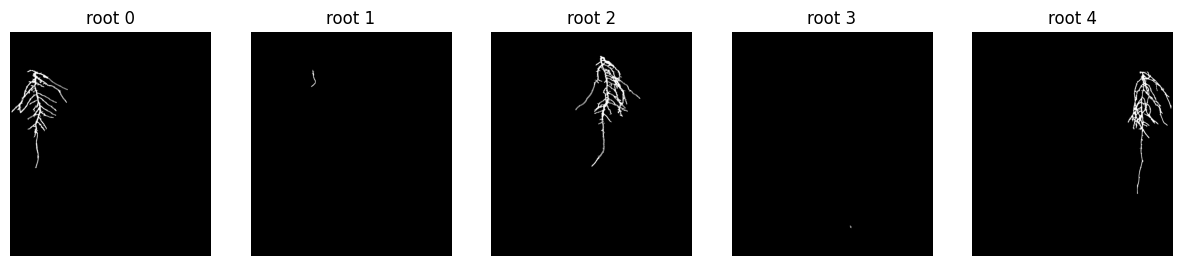

In [11]:
root1_mask, root2_mask, root3_mask, root4_mask, root5_mask = root_masks

plt.figure(figsize=(15, 5))
for i, m in enumerate(root_masks):
    plt.subplot(1, 5, i+1)
    plt.imshow(m, cmap='gray')
    plt.title(f'root {i}')
    plt.axis('off')
plt.show()

In [13]:
import os

save_dir = '/Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6'

# Ensure the save directory exists
os.makedirs(save_dir, exist_ok=True)

# Save the entire figure with all root masks
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for i, m in enumerate(root_masks):
    axs[i].imshow(m, cmap='gray')
    axs[i].set_title(f"root {i}")
    axs[i].axis('off')

# Save the full figure to disk
full_figure_path = os.path.join(save_dir, "04_task6_roots.png")
plt.savefig(full_figure_path, bbox_inches='tight')
print(f"Saved combined figure: {full_figure_path}")
plt.close()


Saved combined figure: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/04_task6_roots.png


In [14]:
# Save each root mask as a separate image
for i, mask in enumerate(root_masks):
    filename = os.path.join(save_dir, f"root_{i + 1}.png")
    cv2.imwrite(filename, mask)
    print(f"Saved: {filename}")


Saved: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/root_1.png
Saved: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/root_2.png
Saved: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/root_3.png
Saved: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/root_4.png
Saved: /Volumes/T7/Artificial Intelligence/YEAR 2.1/Block B retake/task6/04_task6/root_5.png
